In [1]:
import argparse
import os
import json
import torch
import torch.nn as nn
from utilities.config import Config
from environment.unity import UnityEnv
from network.bodies import Actor, FCBody, Critic
from network.ddpg import DDPGNetwork
from agent.memory_replay import MemoryReplayAgent

In [2]:
config_file = 'config.json'

In [3]:
with open(config_file) as f:
    args = json.load(f)
    config = Config()
    config.merge(args)

    config.env = UnityEnv(config.env_name, config.train_mode)

    config.actor_net_func = lambda: Actor(
        FCBody(config.env.state_dim, gate_func=nn.ReLU), 
        config.env.action_dim,
        nn.Tanh)

    config.critic_net_func = lambda: Critic(
        config.env.state_dim,
        config.env.action_dim)

    config.actor_opt_func = lambda params: \
        torch.optim.Adam(params, config.actor_learning_rate)

    config.critic_opt_func = lambda params: \
        torch.optim.Adam(params, config.critic_learning_rate, weight_decay=config.weight_decay)

    config.network_func = lambda: DDPGNetwork(config)

Device cuda
Loading tennis in Train Mode True


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
from abc import ABC, abstractmethod
from collections import deque
import torch
import numpy as np

class BaseAgent(ABC):
    def __init__(self, config):
        self.config = config
        
    def save(self, file_name):
        torch.save(self.config.network.state_dict(), f'{file_name}.pth')

    def load(self, file_name):
        # the map_location call transfers the storage already to the correct device
        state_dict = torch.load(f'{file_name}.pth', map_location=lambda storage, loc: storage)
        self.config.network.load_state_dict(state_dict)

    @abstractmethod
    def step(self):
        pass

    @abstractmethod
    def save(self, file_name):
        pass

    @abstractmethod
    def load(self, file_name):
        pass

    def train(self):
        '''
            Train an agent for a given number of episodes
        '''
        config = self.config
        scores_deque = deque(maxlen=config.reward_window_size)
        scores = []
        for i_episode in range(1, config.num_episodes+1):
            self.reset()
            episide_score = np.zeros(self.env.num_agents)
            for _ in range(config.max_steps):
                score, done = self.step()
                # score and done are vectors
                episide_score += score
                if np.any(done):
                    break 

            # get the maximum score over both agents
            episide_score = np.max(episide_score)
            scores_deque.append(episide_score)
            scores.append(episide_score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_deque)), end="")
            
            if i_episode % config.save_interval == 0:
                self.save('checkpoint.pth', scores)

            if i_episode % config.log_interval == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                    i_episode, np.mean(scores_deque)))

        return scores

    def run(self):
        '''
            Run an agent for one episode without training
        '''
        total_score = 0
        for _ in range(self.config.max_steps):
            score, done = self.step(skip_training=True)
            total_score += score
            if done:
                break
        print(f'Total score {total_score}')

In [5]:
import numpy as np
import torch
import torch.nn as nn
from utilities.storage import ReplayBuffer

class MemoryReplayAgent(BaseAgent):
    '''
        This object is basically a shell that can train
        for an agent that can utilize a experience memory buffer
    '''
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.env = config.env
        self.network = config.network_func()
        self.reset()
        self.memory = ReplayBuffer(self.env.action_dim, config.buffer_size, config.batch_size, config.device)

    def reset(self):
        self.state = self.env.reset()

    def step(self, skip_training=False):
        '''
            Save experience in replay memory, and use random sample from buffer to learn.
            return the reward received on this step
        '''
        action = [self.network.act(state) for state in self.state]
        next_state, reward, done = self.env.step(action)

        if not skip_training:
            # Save the experience to the memory buffer, for each agent
            for s,a,r,n,d in zip(self.state, action, reward, next_state, done):
                self.memory.add(s, a, r, n, d)

            # Learn, if enough samples are available in memory
            if len(self.memory) > self.config.batch_size:
                experiences = self.memory.sample()
                self.network.learn(experiences, self.config.gamma)

        # store the next state
        self.state = next_state

        return reward, done

    def save(self, file_name, metrics):
        '''
            Save the networks to a file
        '''
        torch.save(
            {
                'actor': self.network.actor_local.state_dict(),
                'critic': self.network.critic_local.state_dict(),
                'metrics': metrics,
            },
            file_name)

    def load(self, file_name):
        '''
            Restore the actor/critic networks
        '''
        info = torch.load(file_name)
        self.actor_local.load_state_dict(info['actor'])
        self.critic_local.load_state_dict(info['critic'])

In [6]:
agent = MemoryReplayAgent(config)


[array([-0.10150523,  0.09366773], dtype=float32), array([-0.10273389,  0.10842322], dtype=float32)]


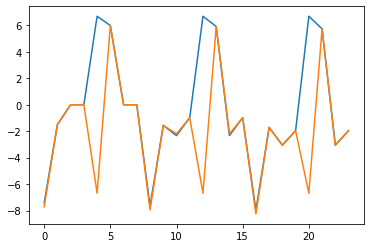

In [27]:
import matplotlib.pyplot as plt

agent.step()
fig,ax = plt.subplots()
ax.plot(agent.state[0])
ax.plot(agent.state[1])